In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import time
import itertools
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
from sklearn.model_selection import train_test_split
os.getcwd()
os.chdir(r'C:\Users\Haneef Usmani\Desktop\STAT 303-2\Project')

In [ ]:
flight = pd.read_csv('./data/flights_clean.csv')

In [6]:
# split flight into train and test
train, test = train_test_split(flight, test_size=0.2)
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [7]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('(departure_delay)~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [8]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [9]:
models_best = backward_selection()

Processed  16 models on 15 predictors in 88.34631609916687 seconds.
Processed  15 models on 14 predictors in 57.87614393234253 seconds.
Processed  14 models on 13 predictors in 42.571730613708496 seconds.
Processed  13 models on 12 predictors in 34.58789849281311 seconds.
Processed  12 models on 11 predictors in 28.954134941101074 seconds.
Processed  11 models on 10 predictors in 25.023990869522095 seconds.
Processed  10 models on 9 predictors in 19.47510290145874 seconds.
Processed  9 models on 8 predictors in 15.468644618988037 seconds.
Processed  8 models on 7 predictors in 12.436475992202759 seconds.
Processed  7 models on 6 predictors in 9.425689935684204 seconds.
Processed  6 models on 5 predictors in 7.500488042831421 seconds.
Processed  5 models on 4 predictors in 5.463268041610718 seconds.
Processed  4 models on 3 predictors in 3.0997989177703857 seconds.
Processed  3 models on 2 predictors in 1.9734046459197998 seconds.
Processed  2 models on 1 predictors in 1.175168514251709

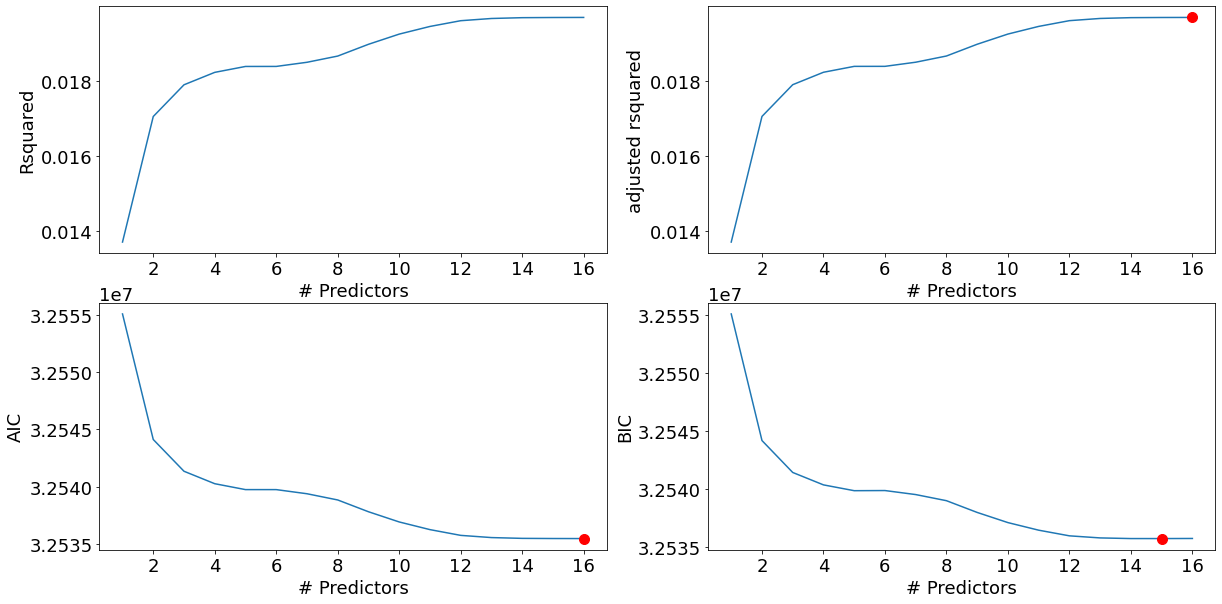

In [13]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [16]:
best_fwd_reg_model = models_best['model'][16]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4047.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:24:54   Log-Likelihood:            -1.6268e+07
No. Observations:             3225535   AIC:                         3.254e+07
Df Residuals:                 3225518   BIC:                         3.254e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -29.4345      1.043    -28.231      0.000     -31.478     -27.391
day                         1.1008      0.034     32.239      0.000       1.034       1.168
day_of_week                -0.3572      0.011    -34.005      0.000      -0.378      -0.337
destination_latitude       -0.0426      0.005     -8.538      0.000      -0.052      -0.033
destination_longitude       0.0268      0.002     14.533      0.000       0.023       0.030
distance                   -0.0013      0.000     -3.995      0.000      -0.002      -0.001
month                      33.6003      1.040     32.322      0.000      31.563      35.638
origin_latitude            -0.1262      0.005    -25.320      0.000      -0.136      -0.116
origin_longitude            0.0117      0.002      5.215      0.000       0.007       0.016
scheduled_arrival           0.0045   9.27e-05     48.722      0.000       0.004       0.005
scheduled_departure         0.0120   9.78e-05    122.616      0.000       0.012       0.012
scheduled_time              0.0190      0.003      7.407      0.000       0.014       0.024
taxi_in                     0.0915      0.004     24.579      0.000       0.084       0.099
taxi_out                    0.2222      0.002     93.090      0.000       0.218       0.227
day_of_year                -1.1064      0.034    -32.424      0.000      -1.173      -1.040
origin_temperature         -0.0443      0.002    -22.029      0.000      -0.048      -0.040
destination_temperature    -0.0050      0.002     -2.497      0.013      -0.009      -0.001
==============================================================================
Omnibus:                  4345688.267   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2014911843.580
Skew:                           7.498   Prob(JB):                         0.00
Kurtosis:                     124.521   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

37.01460832397214